In [459]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve, auc, recall_score, accuracy_score, precision_score
from catboost import CatBoostClassifier
import time
import os
from sklearn.linear_model import LogisticRegression

In [446]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.prompt { min-width:10ex !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x) 

/tmp/ipykernel_119769/437858164.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display

/tmp/ipykernel_119769/437858164.py:1: DeprecationWarning:

Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [3]:
df_with_feats = pd.read_parquet("../data/train_with_feats_v4.parquet")

In [4]:
df_train, df_val = train_test_split(df_with_feats, test_size=0.2, random_state=42, stratify=df_with_feats.buy_post)

In [5]:
information_value = pd.read_csv('../data/feature_information_value.csv', sep=';')

IV < 0,02 — отсутствует; 

0,02 ≤ IV <0,1 — низкая; 

0,1 ≤ IV < 0,3 — средняя; 


IV ≥ 0,3 — высокая. 


In [6]:
best_iv_feats = information_value[information_value["IV"] >= 0.02].feature.values
len(best_iv_feats)

42

In [7]:
information_value[information_value["IV"] >= 0.02].sort_values(by="IV", ascending=False)

,feature,IV
62,receipt_count,0.430457
30,weekends_std,0.243150
69,strange_std,0.237534
47,dom_std,0.161640
1,revenue_sum_count_14d,0.155249
65,revenue_sum_count_28d,0.155249
3,revenue_sum_count_7d,0.155249
35,was_promo_std,0.120205
46,fun_sum,0.105191
88,dow_std,0.097692


### Modeling [gain]

importance by gain

In [8]:
df_train["buy_post"].value_counts()

buy_post
1    287276
0    112724
Name: count, dtype: int64

In [9]:
scale_pos_weight = 112724/ 287276

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': "binary",
    'num_leaves': 50,
    'max_depth': 20,
    'learning_rate': 0.15,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'min_child_samples': 50,
    'n_jobs': 4,
    'n_estimators': 300,
    'scale_pos_weight': scale_pos_weight,
    'class_weight': None,
    'colsample_bytree': 0.8,
    'importance_type': 'gain',
    'min_child_samples': 50,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample_for_bin': 200000,
}

In [11]:
current_feats = information_value.feature.values
len(current_feats)

108

In [12]:
lgbm_model = lightgbm.LGBMModel(**params)

In [13]:
lgbm_model.fit(df_train[current_feats], df_train["buy_post"], )

[LightGBM] [Info] Number of positive: 287276, number of negative: 112724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22195
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.718190 -> initscore=0.935501
[LightGBM] [Info] Start training from score 0.935501


LGBMModel(colsample_bytree=0.8, importance_type='gain', learning_rate=0.15,
          max_depth=20, metric='binary', min_child_samples=50, n_estimators=300,
          n_jobs=4, num_leaves=50, objective='binary',
          scale_pos_weight=0.3923892006293599, subsample=0.8, subsample_freq=1)

In [14]:
y_pred_lgbm = lgbm_model.predict(df_val[current_feats])

In [15]:
def with_cutoff(y_pred, cut_off):
    return [int(x > cut_off) for x in y_pred]

In [16]:
current_cut_off = 0.5

print(classification_report(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off)))

              precision    recall  f1-score   support

           0       0.43      0.68      0.52     28181
           1       0.84      0.64      0.72     71819

    accuracy                           0.65    100000
   macro avg       0.63      0.66      0.62    100000
weighted avg       0.72      0.65      0.67    100000



In [17]:
f1_score(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off))

0.7234429482972651

In [18]:
roc_auc_score(df_val["buy_post"], y_pred_lgbm)

0.7246865524565382

In [19]:
def get_feats_importances(model, type_):
    df = pd.DataFrame()
    df["feature"] = model.feature_name_
    df[type_] = model.feature_importances_
    df = df.merge(information_value, on="feature", how="inner")
    return df

In [20]:
imp_gain = get_feats_importances(lgbm_model, "gain")

### Modeling [splits]

importance by splits

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': "binary",
    'num_leaves': 50,
    'max_depth': 20,
    'learning_rate': 0.15,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'min_child_samples': 50,
    'n_jobs': 4,
    'n_estimators': 300,
    'scale_pos_weight': scale_pos_weight,
    'class_weight': None,
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'min_child_samples': 50,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample_for_bin': 200000,
}

In [22]:
lgbm_model = lightgbm.LGBMModel(**params)
lgbm_model.fit(df_train[current_feats], df_train["buy_post"], )
y_pred_lgbm = lgbm_model.predict(df_val[current_feats])

[LightGBM] [Info] Number of positive: 287276, number of negative: 112724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22195
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.718190 -> initscore=0.935501
[LightGBM] [Info] Start training from score 0.935501


In [23]:
imp_splits = get_feats_importances(lgbm_model, "split")

In [24]:
df_imp = imp_gain.merge(imp_splits[['feature', 'split']], on='feature', how='left')

### Feature selection

Выбрать топ 30 фичей по каждому importance

In [273]:
top = 30

In [274]:
gain_feat_top_30 = df_imp.sort_values(by='gain', ascending=False).reset_index()[:top]["feature"].values
df_imp.sort_values(by='gain', ascending=False).reset_index()[:top]

,index,feature,gain,IV,split
0,62,receipt_count,56311.500502,0.430457,224
1,47,dom_std,16949.701377,0.161640,449
2,1,revenue_sum_count_14d,16784.860393,0.155249,218
3,102,first_half_std,11165.476215,0.012299,290
4,72,dom_mean,7771.655986,0.078925,408
5,69,strange_std,3399.754175,0.237534,93
6,76,dom_median,2866.159276,0.057772,260
7,3,revenue_sum_count_7d,2708.055741,0.155249,24
8,12,minutes_mean,2701.207575,0.003522,393
9,105,second_half_min,2368.588671,0.003584,255


In [275]:
split_feat_top_30 = df_imp.sort_values(by='split', ascending=False).reset_index()[:top]["feature"].values
df_imp.sort_values(by='split', ascending=False).reset_index()[:top]

,index,feature,gain,IV,split
0,47,dom_std,16949.701377,0.161640,449
1,72,dom_mean,7771.655986,0.078925,408
2,12,minutes_mean,2701.207575,0.003522,393
3,104,sqm_place_mean,2119.673971,0.002517,314
4,96,cosine_similarity,2194.801603,0.047049,313
5,102,first_half_std,11165.476215,0.012299,290
6,31,revenue_sum_std_7d,2026.566039,0.005667,287
7,21,revenue_sum_sum_7d,1882.393075,0.043770,261
8,76,dom_median,2866.159276,0.057772,260
9,105,second_half_min,2368.588671,0.003584,255


In [276]:
best_feats_by_importance = list(set(gain_feat_top_30).union(split_feat_top_30))

In [277]:
len(best_feats_by_importance)

37

### Train best model

Обучение модели ligthgbm

In [278]:
def plot_roc_auc_curve(y_true, y_pred, renderer='notebook'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show(renderer=renderer)

In [359]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': "binary",
    'num_leaves': 25,
    'max_depth': 10,
    'learning_rate': 0.2,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 1,
    'min_child_samples': 50,
    'n_jobs': 4,
    'n_estimators': 120,
    'class_weight': None,
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'min_child_samples': 25,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'random_state': 42,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample_for_bin': 200000,
    'scale_pos_weight': 0.41,
    'scale_pos_weight': scale_pos_weight,
}

In [447]:
scale_pos_weight

0.3923892006293599

In [448]:
current_feats = best_feats_by_importance

In [449]:
lgbm_model = lightgbm.LGBMModel(**params)
lgbm_model.fit(df_train[current_feats], df_train["buy_post"], )
y_pred_lgbm = lgbm_model.predict(df_val[current_feats])

[LightGBM] [Info] Number of positive: 287276, number of negative: 112724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8172
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.718190 -> initscore=0.935501
[LightGBM] [Info] Start training from score 0.935501


In [450]:
y_pred_lgbm = lgbm_model.predict(df_val[current_feats])
y_train_lgbm = lgbm_model.predict(df_train[current_feats])

In [460]:
current_cut_off = 0.53


print(classification_report(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off)))
print(classification_report(df_train["buy_post"], with_cutoff(y_train_lgbm, current_cut_off)))
print(f"f1 score - {f1_score(df_val['buy_post'], with_cutoff(y_pred_lgbm, current_cut_off))}")
print(f"recall score - {recall_score(df_val['buy_post'], with_cutoff(y_pred_lgbm, current_cut_off))}")
print(f"precision score - {precision_score(df_val['buy_post'], with_cutoff(y_pred_lgbm, current_cut_off))}")
print(f"accuracy score - {accuracy_score(df_val['buy_post'], with_cutoff(y_pred_lgbm, current_cut_off))}")
print(f"roc_auc score - {roc_auc_score(df_val['buy_post'], y_pred_lgbm)}")

              precision    recall  f1-score   support

           0       0.41      0.76      0.53     28181
           1       0.86      0.56      0.68     71819

    accuracy                           0.62    100000
   macro avg       0.63      0.66      0.60    100000
weighted avg       0.73      0.62      0.64    100000

              precision    recall  f1-score   support

           0       0.42      0.79      0.55    112724
           1       0.87      0.57      0.69    287276

    accuracy                           0.63    400000
   macro avg       0.65      0.68      0.62    400000
weighted avg       0.75      0.63      0.65    400000

f1 score - 0.6801659555884032
recall score - 0.5638201590108467
precision score - 0.8570128468327372
accuracy score - 0.61918
roc_auc score - 0.7272419712871481


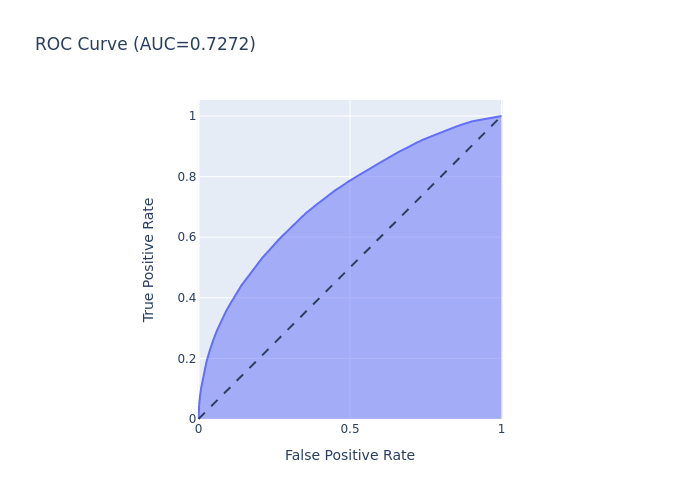

In [452]:
plot_roc_auc_curve(df_val['buy_post'], y_pred_lgbm, 'png')

In [453]:
current_cut_off = 0.5

print(classification_report(df_val["buy_post"], with_cutoff(y_pred_lgbm, current_cut_off)))
print(f"f1 score - {f1_score(df_val['buy_post'], with_cutoff(y_pred_lgbm, current_cut_off))}")
print(f"roc_auc score - {roc_auc_score(df_val['buy_post'], y_pred_lgbm)}")

              precision    recall  f1-score   support

           0       0.42      0.71      0.53     28181
           1       0.85      0.61      0.71     71819

    accuracy                           0.64    100000
   macro avg       0.63      0.66      0.62    100000
weighted avg       0.73      0.64      0.66    100000

f1 score - 0.7103061817712033
roc_auc score - 0.7272419712871481


### Test


Отправка тестовых данных

In [454]:
df_test = pd.read_parquet("../data/test_with_feats_v4.parquet")

In [455]:
y_test_pred = lgbm_model.predict(df_test[current_feats])

In [456]:
df_test["buy_post"] = with_cutoff(y_test_pred, current_cut_off)

In [457]:
df_test[["customer_id", "buy_post"]].describe()

,customer_id,buy_post
count,112334.000000,112334.000000
mean,20748611.321951,0.446009
std,11582578.505840,0.497079
min,52341.000000,0.000000
25%,11041231.250000,0.000000
50%,22155898.000000,0.000000
75%,28861910.500000,1.000000
max,46668221.000000,1.000000


In [458]:
len(current_feats)

37

In [445]:
df_test[["customer_id", "buy_post"]].to_csv("top37_by_imp_feats_lgbm_53cut.csv", sep=';', index=False)